In [1]:
from qtpg.team import Team
from qtpg.learner import Learner
from qtpg.program import Program
from qtpg.rule import Rule
from qtpg.figure13 import Figure13
from qtpg.figure13_hole_in_wall import Figure13HoleInWall
from qtpg.figure12 import Figure12
from qtpg.figure9 import Figure9
from qtpg.figureHeywood import FigureHeywood
from qtpg.search_manager import SearchManager
import numpy as np
import uuid
import copy
import matplotlib.pyplot as plt

In [2]:
def check_overlap(state, region):
    if state[region[0]] == region[1] and region[2] <= state[not region[0]] <= region[3]:
        return True
    return False

def check_intersect(one, two):
    print(f'First region: {one}')
    print(f'Second region: {two}')
    firsts = []
    for i in range(one[2], one[3]+1):
        coord = [0, 0]
        coord[one[0]] = one[1]
        coord[not one[0]] = i
        firsts.append(coord)
    print('firsts---')
    print(firsts)
    seconds = []
    for i in range(two[2], two[3]+1):
        coord = [0, 0]
        coord[two[0]] = two[1]
        coord[not two[0]] = i
        seconds.append(coord)
    print('seconds---')
    print(seconds)

    pop_index = 0
    found = False
    
    for n in range(len(firsts)):
        for m in range(len(seconds)):
            if firsts[n] == seconds[m] and not found:
                print(f'popped! --> {firsts[n]} == {seconds[m]}')
                found = True
                pop_index = n
    
    if found:
        firsts.pop(pop_index)
    else:
        return []
    
    print('clipped firsts ----')
    print(firsts)
    
    print('new regions---')

    new_firsts = []

    region = [one[0], one[1], one[2], 0]
    for i in range(len(firsts)):
        if i > 0:
            before = firsts[i]
            if not firsts[i][not one[0]]-1 == firsts[i-1][not one[0]]:
                new_firsts.append(region)
                region = [one[0], one[1], i+1, i+1]
            else:
                region[3] = region[3]+1
    if len(new_firsts) == 0:
        new_firsts.append(region)

    print('firsts')
    for region in new_firsts:
        print(region)
    print('seconds')
    print(two)
    return new_firsts, two

In [3]:
# one = [1, 2, 0, 4]
# two = [0, 4, 0, 3]
one = [0, 0, 0, 4]
two = [0, 4, 0, 4]
check_intersect(one, two)

First region: [0, 0, 0, 4]
Second region: [0, 4, 0, 4]
firsts---
[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4]]
seconds---
[[4, 0], [4, 1], [4, 2], [4, 3], [4, 4]]


[]

In [4]:
# env params
memorySize = 40
legalMove = 0.1
illegalMove = -0.01
outOfBounds = 0.0
memoryRepeat = -0.01
# memoryRepeat = 0.0
goalReached = 100

# envName = 'Figure 13'
# start_env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# end_env = Figure13(5, 5, (0, 0), (2, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

# envName = 'Figure 13 Hole in Wall'
# start_env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# end_env = Figure13HoleInWall(5, 5, (0, 0), (2, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

# envName = 'Figure 12'
# start_env = Figure12(5, 5, (4, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# end_env = Figure12(5, 5, (0, 0), (4, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

# envName = 'Figure 9'
# start_env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# end_env = Figure9(10, 10, (0, 3), (4, 9), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

envName = 'Heywood'
start_env = FigureHeywood(10, 10, (4, 4), (0, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
end_env = FigureHeywood(10, 10, (0, 4), (4, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

In [5]:
maxTeamPool = 5

# init everything for new run
startSearchManager = SearchManager(maxTeamPool)

adam_and_eve = []
start_env.reset()
init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
init_team.init_search(start_env, [2, 3])
adam_and_eve.append(init_team)
win = False
for adam in adam_and_eve:
    data = [adam, win]
    startSearchManager.evaluate_team(data)

endSearchManager = SearchManager(maxTeamPool)
    
adam_and_eve = []
end_env.reset()
init_team = Team(uuid.uuid4(), 0, 0, 1, 1, 0)
init_team.init_search(end_env, [0, 1])
adam_and_eve.append(init_team)
win = False
for adam in adam_and_eve:
    data = [adam, win]
    endSearchManager.evaluate_team(data)

intersect = False


# variables for tracking fitness, for curves
scores = []
gens = []
maxes = []
averages = []
mins = []

run_winners = []
runs_score_track = []


gen = 0
while (not intersect):
    print('start_team')
    for parent in startSearchManager.teamPool:
        # only run if the team has not yet won
        if parent not in startSearchManager.winners:
#                 print(f'Parent: {parent.id}')
    #             print(f'Start: {parent.start_state}')
            start_env.current_state = parent.start_state

            # make offspring from parent, then let that offspring make a new rule
            child = copy.deepcopy(parent)
            child.id = uuid.uuid4()
            win = child.search_no_back_track(start_env)
            startSearchManager.evaluate_team([child, win])
            scores.append(parent)
        else:
            scores.append(parent)
    print('end team')
    for parent in endSearchManager.teamPool:
        # only run if the team has not yet won
        if parent not in endSearchManager.winners:
#                 print(f'Parent: {parent.id}')
    #             print(f'Start: {parent.start_state}')
            end_env.current_state = parent.start_state

            # make offspring from parent, then let that offspring make a new rule
            child = copy.deepcopy(parent)
            child.id = uuid.uuid4()
#             win = child.search_no_back_track(end_env)
            win = child.goal_start_search(end_env)
            endSearchManager.evaluate_team([child, win])
            scores.append(parent)
        else:
            scores.append(parent)
#     if startSearchManager.teamPool[0] overlaps with endSearchManager.teamPool[0].mostRecent.
    print(start_env.current_state)
    print(endSearchManager.teamPool[0].mostRecent.program.rule.region)
#     if check_overlap(start_env.current_state, endSearchManager.teamPool[0].mostRecent.program.rule.region):
#         overlap = True
#         print('overlap!')

    regions = check_intersect(
        startSearchManager.teamPool[0].mostRecent.program.rule.region, 
        endSearchManager.teamPool[0].mostRecent.program.rule.region
    )
    print('REGIONS')
    print(regions)
    if len(regions) > 0:
        print('HEYYY')
        intersect = True
        print('REGIONS!')
        print(regions[0][0])
        startSearchManager.teamPool[0].mostRecent.program.rule.region = regions[0][0]
        if len(regions[0]) > 1:
            print('regions 2:')
            print(regions[0][1])
            rule = copy.deepcopy(startSearchManager.teamPool[0].mostRecent.program.rule)
            rule.region = regions[0][1]
            learner = Learner(uuid.uuid4(), rule)
            startSearchManager.teamPool[0].learners.append(learner)
    
    total = 0
    max_fitness = -100
    min_fitness = 100

    for team in scores:
        total += team.fitness
        if team.fitness > max_fitness:
            max_fitness = team.fitness
        if team.fitness < min_fitness:
            min_fitness = team.fitness
    average_fitness = total / len(startSearchManager.teamPool) + len(endSearchManager.teamPool)
    maxes.append(max_fitness)
    averages.append(average_fitness)
    mins.append(min_fitness)
    gens.append(gen)    
    gen += 1
    print(gen)

    

runs_score_track.append({'run': 1, 'maxes': maxes, 'averages': averages, 'mins': mins}) 
    
    
print('starts:')
for learner in startSearchManager.teamPool[0].learners:
    print(learner.program.rule.region)
                
print('ends:')
for learner in endSearchManager.teamPool[0].learners:
    print(learner.program.rule.region)

start_team
end team
[1, 4, 3, 6]
[0, 3, 4, 8]
[1, 4, 3, 5]
[1, 4, 4, 5]
(0, 8)
[0, 4, 4, 4]
First region: [1, 8, 0, 9]
Second region: [0, 4, 4, 4]
firsts---
[[0, 8], [1, 8], [2, 8], [3, 8], [4, 8], [5, 8], [6, 8], [7, 8], [8, 8], [9, 8]]
seconds---
[[4, 4]]
REGIONS
[]
1
start_team
end team
[1, 4, 4, 5]
[0, 5, 1, 4]
[1, 4, 4, 5]
[0, 5, 1, 4]
(9, 0)
[1, 3, 4, 5]
First region: [0, 9, 0, 9]
Second region: [1, 3, 4, 5]
firsts---
[[9, 0], [9, 1], [9, 2], [9, 3], [9, 4], [9, 5], [9, 6], [9, 7], [9, 8], [9, 9]]
seconds---
[[4, 3], [5, 3]]
REGIONS
[]
2
start_team
end team
[1, 3, 4, 5]
[0, 5, 1, 4]
[1, 1, 1, 8]
[1, 0, 1, 8]
(9, 9)
[0, 1, 0, 8]
First region: [1, 9, 0, 9]
Second region: [0, 1, 0, 8]
firsts---
[[0, 9], [1, 9], [2, 9], [3, 9], [4, 9], [5, 9], [6, 9], [7, 9], [8, 9], [9, 9]]
seconds---
[[1, 0], [1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8]]
REGIONS
[]
3
start_team
end team
[0, 1, 0, 8]
[1, 0, 1, 8]
(4, 1)
[0, 1, 0, 8]
First region: [0, 4, 0, 1]
Second region: [0, 1, 

In [6]:
first_team = startSearchManager.teamPool[0]
second_team = endSearchManager.teamPool[0]
first_team.learners.extend(second_team.learners)
team = first_team
team.prune_single_cell_regions()
for learner in team.learners:
    print(learner.program.rule.region)

PRUNING SINGLE CELL REGIONS!
338
239
[0, 0, 0, 6]
[0, 0, 8, 9]
[1, 7, 0, 7]
[0, 8, 0, 4]
[0, 8, 6, 9]
[0, 8, 0, 7]
[1, 8, 0, 1]
[1, 8, 3, 9]
[1, 8, 1, 9]
[0, 0, 2, 9]
[1, 1, 0, 8]
[0, 9, 0, 1]
[0, 9, 3, 9]
[0, 9, 0, 2]
[0, 9, 4, 9]
[0, 8, 0, 8]
[1, 9, 0, 7]
[0, 8, 0, 5]
[0, 8, 7, 9]
[0, 9, 1, 9]
[1, 0, 0, 3]
[1, 0, 5, 9]
[1, 1, 0, 4]
[1, 1, 6, 9]
[0, 5, 1, 5]
[1, 0, 0, 7]
[0, 8, 0, 4]
[0, 8, 6, 9]
[0, 8, 1, 9]
[1, 0, 0, 2]
[1, 0, 4, 9]
[1, 1, 0, 8]
[0, 9, 0, 5]
[0, 9, 7, 9]
[0, 9, 0, 6]
[0, 9, 8, 9]
[1, 7, 0, 4]
[1, 7, 6, 9]
[1, 8, 0, 3]
[1, 8, 5, 9]
[1, 8, 1, 9]
[0, 0, 0, 4]
[0, 0, 6, 9]
[0, 0, 1, 9]
[1, 0, 1, 9]
[0, 0, 2, 9]
[1, 1, 0, 8]
[0, 9, 0, 4]
[0, 9, 6, 9]
[0, 8, 2, 9]
[1, 1, 0, 7]
[0, 8, 0, 8]
[1, 9, 0, 7]
[0, 8, 0, 3]
[0, 8, 5, 9]
[0, 8, 0, 2]
[0, 8, 4, 9]
[0, 8, 0, 4]
[0, 8, 6, 9]
[0, 9, 0, 1]
[0, 9, 3, 9]
[0, 8, 0, 4]
[0, 8, 6, 9]
[0, 8, 0, 8]
[1, 9, 0, 4]
[1, 9, 6, 9]
[0, 5, 8, 9]
[1, 7, 0, 5]
[1, 7, 7, 9]
[0, 6, 8, 9]
[1, 7, 0, 8]
[0, 9, 0, 1]
[0, 9, 3, 9]
[0, 8, 0, 8]
[

In [7]:
# #fitness curves
# x = []
# y = []
# average_maxes = np.zeros(len(gens))
# print(average_maxes)
# print(gens)

# for i in range(len(runs_score_track)):
#     print(i)
# print(runs_score_track[0]['maxes'][4])
# print(gens)
# for i in range(len(gens)):
#     print(i)
#     for q in range(len(runs_score_track)):
#         print(q)
#         average_maxes[i] += runs_score_track[q]['maxes'][i]
#     average_maxes[i] /= len(runs_score_track)
    
# for gen in gens:
#     x.append(gen)

# plt.title(f'Average max score over {len(runs_score_track)} runs for {envName}')
# plt.xlabel('Generation')
# plt.ylabel('Average Max Score')
# plt.plot(x, average_maxes)
# plt.show()

In [8]:
# for learner in team.learners:
#     print(learner.program.rule.region)
# team.learners[len(team.learners)-1].program.rule.region = [0, 0, 0, 1]

In [9]:
team.discount = 0.9
team.alpha = 0.5
# for learner in team.learners:
#     print(learner.program.rule.region)

# env = Figure13(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# env = Figure13HoleInWall(5, 5, (2, 4), (0, 0), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
# env = Figure9(10, 10, (4, 9), (0, 3), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)
env = FigureHeywood(10, 10, (4, 4), (0, 4), memorySize, legalMove, illegalMove, outOfBounds, memoryRepeat, goalReached)

for i in range(env.rows):
#     print(f'Epoch: {i+1} --------')
    env.reset()
#     print(f'curr -> {env.current_state}')
    win = False
    selected_learner = team.select_learner(env, [0, 0, 0, 0])
    while not win:
        win, needs_update, reward, winning_action = team.q_evaluation(env, selected_learner)
#         print(reward)
#         print('hi')
        if not win:
            selected_learner = team.select_learner(env, selected_learner.program.rule.region)
            team.transition_update(reward, winning_action, needs_update, selected_learner)

    team.final_update(reward, winning_action, needs_update)

print(win)
for learner in team.learners:
    print(f'{learner.program.rule.region}')
    for i in range(len(learner.program.rule.action_set)):
          print(f'{learner.program.rule.action_set[i]} --> {learner.program.rule.value_set[i]}')

regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 1, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 7]
[0, 0, 0, 6] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 1, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 0, 6] --> [2, 3]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 0, 7] --> [2, 3]
we chose --> [0, 0, 0, 6]
value set is 0, action selected --> 3
[0, 0, 0, 6]
[2, 3]
[0, 0]
3
(0, 3)
value set is 0, action selected --> 3
[0, 0, 0, 6]
[2, 3]
[0, 0]
3
(0, 2)
value set is 0, action selected --> 2
[0, 0, 0, 6]
[2, 3]
[0, 0]
2
(0, 3)
value set is 0, action selected --> 2
[0,

[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 0
[1, 7, 0, 8]
[0, 1]
[0, 0]
0
(1, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 0
[1, 7, 0, 8]
[0, 1]
[0, 0]
0
(1, 7)
value set is 0, action selected --> 0
[1, 7, 0, 8]
[0, 1]
[0, 0]
0
(2, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(1, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0, action selected --> 1
[1, 7, 0, 8]
[0, 1]
[0, 0]
1
(0, 7)
value set is 0,

[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 0
[1, 7, 3, 9]
[0, 1]
[0, 0]
0
(9, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(8, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(7, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(6, 7)
value set is 0, action selected --> 0
[1, 7, 3, 9]
[0, 1]
[0, 0]
0
(7, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(6, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(5, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(4, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(3, 7)
value set is 0, action selected --> 1
[1, 7, 3, 9]
[0, 1]
[0, 0]
1
(2, 7)
Winning action: 1
regions --> [1, 7, 3, 9] is eligible with [1, 7, 0, 7]
regions --> [1, 7, 3, 9] is eligible with [1, 7, 0, 4]
regions --> [1, 7, 3, 9] is eligible with [1, 7, 0, 5]
regions --> [1, 7, 3, 9] is eligible with [1, 7, 0, 8]

regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 1, 9]
[0, 9, 1, 9]
[2, 3]
[0, 0.05]
3
(9, 5)
[0, 9, 1, 9]
[2, 3]
[0, 0.05]
3
(9, 4)
[0, 9, 1, 9]
[2, 3]
[0, 0.05]
3
(9, 3)
[0, 9, 1, 9]
[2, 3]
[0, 0.05]
3
(9, 2)
[0, 9, 1, 9]
[2, 3]
[0, 0.05]
3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.05]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions -->

1
(3, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(2, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(1, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(0, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(0, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(0, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(1, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(2, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(3, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(4, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(3, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(4, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(5, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(4, 1)
value set is 0, action select

[0, 0]
3
(9, 4)
value set is 0, action selected --> 2
[0, 9, 3, 9]
[2, 3]
[0, 0]
2
(9, 5)
value set is 0, action selected --> 3
[0, 9, 3, 9]
[2, 3]
[0, 0]
3
(9, 4)
value set is 0, action selected --> 3
[0, 9, 3, 9]
[2, 3]
[0, 0]
3
(9, 3)
value set is 0, action selected --> 3
[0, 9, 3, 9]
[2, 3]
[0, 0]
3
(9, 2)
Winning action: 3
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 1, 9]
[0, 9, 1, 9]

2
(8, 4)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 3)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 4)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 3)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 2)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 1)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 0)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 1)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 0)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 1)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 2)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 3)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 2)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 3)
value set is 0, action select

[0, 0]
1
(2, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(3, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(4, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(5, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(6, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(5, 1)
value set is 0, action selected --> 1
[1, 1, 0, 8]
[0, 1]
[0, 0]
1
(4, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(5, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(6, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(7, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(8, 1)
value set is 0, action selected --> 0
[1, 1, 0, 8]
[0, 1]
[0, 0]
0
(9, 1)
Winning action: 0
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 2]
regions --> [1, 1, 0, 8] is eligible with 

value set is 0, action selected --> 1
[1, 0, 1, 9]
[0, 1]
[0, 0]
1
(4, 0)
value set is 0, action selected --> 0
[1, 0, 1, 9]
[0, 1]
[0, 0]
0
(5, 0)
value set is 0, action selected --> 1
[1, 0, 1, 9]
[0, 1]
[0, 0]
1
(4, 0)
value set is 0, action selected --> 1
[1, 0, 1, 9]
[0, 1]
[0, 0]
1
(3, 0)
value set is 0, action selected --> 0
[1, 0, 1, 9]
[0, 1]
[0, 0]
0
(4, 0)
value set is 0, action selected --> 0
[1, 0, 1, 9]
[0, 1]
[0, 0]
0
(5, 0)
value set is 0, action selected --> 0
[1, 0, 1, 9]
[0, 1]
[0, 0]
0
(6, 0)
value set is 0, action selected --> 1
[1, 0, 1, 9]
[0, 1]
[0, 0]
1
(5, 0)
value set is 0, action selected --> 1
[1, 0, 1, 9]
[0, 1]
[0, 0]
1
(4, 0)
value set is 0, action selected --> 0
[1, 0, 1, 9]
[0, 1]
[0, 0]
0
(5, 0)
value set is 0, action selected --> 1
[1, 0, 1, 9]
[0, 1]
[0, 0]
1
(4, 0)
value set is 0, action selected --> 0
[1, 0, 1, 9]
[0, 1]
[0, 0]
0
(5, 0)
value set is 0, action selected --> 1
[1, 0, 1, 9]
[0, 1]
[0, 0]
1
(4, 0)
value set is 0, action selected --> 0


[0.14216875, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.14216875, 0]
2
(9, 5)
[0, 9, 0, 5]
[2, 3]
[0.14216875, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 3, 9]
[0, 9, 3, 9]
[2, 3]
[0, 0.08825000000000001]
3
(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.08825000000000001]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0

1
(0, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(1, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(2, 0)
value set is 0, action selected --> 1
[1, 0, 0, 5]
[0, 1]
[0, 0]
1
(1, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(2, 0)
value set is 0, action selected --> 1
[1, 0, 0, 5]
[0, 1]
[0, 0]
1
(1, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(2, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(3, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(4, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(5, 0)
value set is 0, action selected --> 1
[1, 0, 0, 5]
[0, 1]
[0, 0]
1
(4, 0)
value set is 0, action selected --> 1
[1, 0, 0, 5]
[0, 1]
[0, 0]
1
(3, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(4, 0)
value set is 0, action selected --> 0
[1, 0, 0, 5]
[0, 1]
[0, 0]
0
(5, 0)
value set is 0, action select

[0, 0.099]
3
(5, 8)
[0, 5, 8, 9]
[2, 3]
[0, 0.099]
3
(5, 7)
Winning action: 3
regions --> [0, 5, 8, 9] is eligible with [1, 7, 0, 7]
regions --> [0, 5, 8, 9] is eligible with [1, 7, 0, 5]
regions --> [0, 5, 8, 9] is eligible with [1, 7, 0, 8]
regions --> [0, 5, 8, 9] is eligible with [0, 5, 7, 8]
regions --> [0, 5, 8, 9] is eligible with [0, 5, 7, 8]
regions --> [0, 5, 8, 9] is eligible with [1, 7, 0, 8]
regions --> [0, 5, 8, 9] is eligible with [0, 5, 7, 8]
regions --> [0, 5, 8, 9] is eligible with [1, 7, 3, 9]
[1, 7, 0, 7] --> [0, 1]
[1, 7, 0, 5] --> [0, 1]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 3, 9] --> [0, 1]
we chose --> [1, 7, 0, 5]
[1, 7, 0, 5]
[0, 1]
[0.045000000000000005, 0]
0
(6, 7)
Winning action: 0
regions --> [1, 7, 0, 5] is eligible with [1, 7, 0, 7]
regions --> [1, 7, 0, 5] is eligible with [1, 7, 6, 9]
regions --> [1, 7, 0, 5] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 0, 5] i

[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 5]
[0, 9, 0, 5]
[2, 3]
[0.13198046875000002, 0]
2
(9, 3)
[0, 9, 0, 5]
[2, 3]
[0.13198046875000002, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.13198046875000002, 0]
2
(9, 5)
[0, 9, 0, 5]
[2, 3]
[0.13198046875000002, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9

[1, 1, 0, 7]
[0, 1]
[0, 0]
1
(0, 1)
value set is 0, action selected --> 1
[1, 1, 0, 7]
[0, 1]
[0, 0]
1
(0, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(1, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(2, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(3, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(4, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(5, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(6, 1)
value set is 0, action selected --> 1
[1, 1, 0, 7]
[0, 1]
[0, 0]
1
(5, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(6, 1)
value set is 0, action selected --> 1
[1, 1, 0, 7]
[0, 1]
[0, 0]
1
(5, 1)
value set is 0, action selected --> 1
[1, 1, 0, 7]
[0, 1]
[0, 0]
1
(4, 1)
value set is 0, action selected --> 1
[1, 1, 0, 7]
[0, 1]
[0, 0]
1
(3, 1)
value set is 0, action selected --> 0
[1, 1, 0, 7]
[0, 1]
[0, 0]
0
(4, 1)
va

[0, 8, 6, 9] --> [2, 3]
[0, 8, 7, 9] --> [2, 3]
[0, 8, 6, 9] --> [2, 3]
[0, 8, 1, 9] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
[0, 8, 5, 9] --> [2, 3]
[0, 8, 4, 9] --> [2, 3]
[0, 8, 6, 9] --> [2, 3]
[0, 8, 6, 9] --> [2, 3]
[1, 9, 6, 9] --> [0, 1]
[1, 9, 4, 9] --> [0, 1]
[1, 9, 6, 9] --> [0, 1]
[1, 9, 6, 9] --> [0, 1]
[1, 9, 8, 9] --> [0, 1]
[0, 8, 3, 9] --> [2, 3]
[1, 9, 4, 9] --> [0, 1]
[0, 8, 3, 9] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
we chose --> [0, 8, 1, 9]
value set is 0, action selected --> 2
[0, 8, 1, 9]
[2, 3]
[0, 0]
2
(8, 9)
value set is 0, action selected --> 3
[0, 8, 1, 9]
[2, 3]
[0, 0]
3
(8, 8)
value set is 0, action selected --> 2
[0, 8, 1, 9]
[2, 3]
[0, 0]
2
(8, 9)
value set is 0, action selected --> 2
[0, 8, 1, 9]
[2, 3]
[0, 0]
2
(8, 9)
value set is 0, action selected --> 2
[0, 8, 1, 9]
[2, 3]
[0, 0]
2
(8, 9)
value set is 0, action selected --> 3
[0, 8, 1, 9]
[2, 3]
[0, 0]
3
(8, 8)
value set is 0, action selected --> 3
[0, 8, 1, 9]
[2, 3]
[0, 0]
3
(8, 7)
value set is 0, action s

3
(9, 7)
[0, 9, 3, 9]
[2, 3]
[0, 0.20724279531250006]
3
(9, 6)
[0, 9, 3, 9]
[2, 3]
[0, 0.20724279531250006]
3
(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.20724279531250006]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 0.20724279531250006]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 0.20724279531250006]
3
(9, 2)
Winning action: 3
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 6]
[0, 9, 0, 6]
[2, 3]
[0.18325925789062505, 0]


regions --> [0, 9, 0, 4] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 6]
[0, 9, 0, 6]
[2, 3]
[0.18432962894531252, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[0.18432962894531252, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
reg

[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 1, 9]
[0, 9, 1, 9]
[2, 3]
[0, 0.16500667187500004]
3
(9, 5)
[0, 9, 1, 9]
[2, 3]
[0, 0.16500667187500004]
3
(9, 4)
[0, 9, 1, 9]
[2, 3]
[0, 0.16500667187500004]
3
(9, 3)
[0, 9, 1, 9]
[2, 3]
[0, 0.16500667187500004]
3
(9, 2)
[0, 9, 1, 9]
[2, 3]
[0, 0.16500667187500004]
3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.16500667187500004]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eli

(8, 2)
value set is 0, action selected --> 3
[0, 8, 0, 5]
[2, 3]
[0, 0]
3
(8, 1)
value set is 0, action selected --> 3
[0, 8, 0, 5]
[2, 3]
[0, 0]
3
(8, 0)
value set is 0, action selected --> 2
[0, 8, 0, 5]
[2, 3]
[0, 0]
2
(8, 1)
value set is 0, action selected --> 3
[0, 8, 0, 5]
[2, 3]
[0, 0]
3
(8, 0)
value set is 0, action selected --> 2
[0, 8, 0, 5]
[2, 3]
[0, 0]
2
(8, 1)
value set is 0, action selected --> 2
[0, 8, 0, 5]
[2, 3]
[0, 0]
2
(8, 2)
value set is 0, action selected --> 3
[0, 8, 0, 5]
[2, 3]
[0, 0]
3
(8, 1)
value set is 0, action selected --> 2
[0, 8, 0, 5]
[2, 3]
[0, 0]
2
(8, 2)
value set is 0, action selected --> 3
[0, 8, 0, 5]
[2, 3]
[0, 0]
3
(8, 1)
value set is 0, action selected --> 2
[0, 8, 0, 5]
[2, 3]
[0, 0]
2
(8, 2)
value set is 0, action selected --> 3
[0, 8, 0, 5]
[2, 3]
[0, 0]
3
(8, 1)
value set is 0, action selected --> 3
[0, 8, 0, 5]
[2, 3]
[0, 0]
3
(8, 0)
value set is 0, action selected --> 2
[0, 8, 0, 5]
[2, 3]
[0, 0]
2
(8, 1)
value set is 0, action selected

regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
[0, 5, 1, 5] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 0, 2] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
[0, 5, 1, 4] --> [2, 3]
we chose --> [0, 5, 1, 4]
[0, 5, 1, 4]
[2, 3]
[0, 0.045000000000000005]
3
(5, 1)
[0, 5, 1, 4]
[2, 3]
[0, 0.045000000000000005]
3
(5, 0)
Winning action: 3
regions --> [0, 5, 1, 4] is eligible with [1, 0, 5, 9]
regions --> 

value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(3, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(2, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(1, 9)
value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(2, 9)
value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(3, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(2, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(1, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(1, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 1


regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 3, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 3, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 2, 9]
[0, 8, 0, 7] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 5] --> [2, 3]
[0, 8, 1, 9] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 5, 9] --> [2, 3]
[0, 8, 4, 9] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 3, 9] --> [2, 3]
[0, 8, 0, 7] --> [2, 3]
[0, 8, 3, 9] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
we chose --> [0, 8, 0, 8]
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 4)
value set is 0, action selected --> 3
[0, 8, 0, 8]
[2, 3]
[0, 0]
3
(8, 3)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 4)
value set is 0, action selected --> 2
[0, 8, 0, 8]
[2, 3]
[0, 0]
2
(8, 5)
value set is 0, action selected --> 3
[0, 8

[1, 9, 4, 9]
[0, 1]
[0, 0.08750000000000001]
1
(3, 9)
Winning action: 1
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 4]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 4]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 4]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 6]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 4, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 4, 9] is eligible with [0, 3, 4, 9]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 4] --> [0, 1]
[1, 9, 0, 4] --> [0, 1]
[1, 9, 0, 4] --> [0, 1]
[1, 9, 0, 6] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[0, 3, 4, 9] --> [2, 3]
we chose --> [1, 9, 0, 4]
value set is 0, action selected --> 0
[1, 9, 0, 4]
[0, 1]
[0, 0]
0
(4, 9)
value set is 0, action selected --> 0


[2, 3]
[0, 0.2533678183202286]
3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.2533678183202286]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 7, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 2] --> [2, 3]
[1, 0, 5, 9] -->

[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 3, 9] --> [0, 1]
we chose --> [0, 5, 7, 8]
[0, 5, 7, 8]
[2, 3]
[0.07537500000000001, 0]
2
(5, 8)
[0, 5, 7, 8]
[2, 3]
[0.07537500000000001, 0]
2
(5, 9)
Winning action: 2
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [0, 5, 8, 9]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 4, 9]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 6]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 4, 9]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[0, 5, 8, 9] --> [2, 3]
[1, 9, 4, 9] --> [0, 1]
[1, 9, 0, 6] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 4, 9] --> 

regions --> [0, 9, 0, 7] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 8, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 5, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 7, 9]
[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 7, 9] --> [2, 3]
[0, 9, 8, 9] --> [2, 3]
[1, 8, 5, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 

value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(3, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(2, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(1, 9)
value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(2, 9)
value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(3, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(2, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(1, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(1, 9)
value set is 0, action selected --> 0
[1, 9, 0, 7]
[0, 1]
[0, 0]
0
(2, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(1, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 1
[1, 9, 0, 7]
[0, 1]
[0, 0]
1
(0, 9)
value set is 0, action selected --> 1


[0, 8, 2, 9] --> [2, 3]
we chose --> [0, 8, 7, 9]
[0, 8, 7, 9]
[2, 3]
[0, 0.142790625]
3
(8, 8)
[0, 8, 7, 9]
[2, 3]
[0, 0.142790625]
3
(8, 7)
[0, 8, 7, 9]
[2, 3]
[0, 0.142790625]
3
(8, 6)
Winning action: 3
regions --> [0, 8, 7, 9] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 2, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 5, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 4, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 7, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 7, 9]

regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 5, 7, 8] is eligible with [1, 9, 4, 9]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[0, 5, 8, 9] --> [2, 3]
[1, 9, 4, 9] --> [0, 1]
[1, 9, 0, 6] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 4, 9] --> [0, 1]
we chose --> [1, 9, 0, 7]
[1, 9, 0, 7]
[0, 1]
[0.21681780028515626, 0]
0
(6, 9)
[1, 9, 0, 7]
[0, 1]
[0.21681780028515626, 0]
0
(7, 9)
[1, 9, 0, 7]
[0, 1]
[0.21681780028515626, 0]
0
(8, 9)
Winning action: 0
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 7, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 1, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 2, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 5, 9]
regions --> [1, 9, 0, 7] is 

[1, 7, 6, 9]
[0, 1]
[0, 0.14406406250000003]
1
(7, 7)
[1, 7, 6, 9]
[0, 1]
[0, 0.14406406250000003]
1
(6, 7)
[1, 7, 6, 9]
[0, 1]
[0, 0.14406406250000003]
1
(5, 7)
Winning action: 1
regions --> [1, 7, 6, 9] is eligible with [1, 7, 0, 7]
regions --> [1, 7, 6, 9] is eligible with [1, 7, 0, 5]
regions --> [1, 7, 6, 9] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 6, 9] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 6, 9] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 6, 9] is eligible with [1, 7, 3, 9]
[1, 7, 0, 7] --> [0, 1]
[1, 7, 0, 5] --> [0, 1]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 3, 9] --> [0, 1]
we chose --> [1, 7, 3, 9]
[1, 7, 3, 9]
[0, 1]
[0, 0.1158125]
1
(4, 7)
[1, 7, 3, 9]
[0, 1]
[0, 0.1158125]
1
(3, 7)
[1, 7, 3, 9]
[0, 1]
[0, 0.1158125]
1
(2, 7)
Winning action: 1
regions --> 

[0, 8, 2, 9] --> [2, 3]
we chose --> [0, 8, 0, 8]
[0, 8, 0, 8]
[2, 3]
[0.249797177905669, 0]
2
(8, 6)
[0, 8, 0, 8]
[2, 3]
[0.249797177905669, 0]
2
(8, 7)
[0, 8, 0, 8]
[2, 3]
[0.249797177905669, 0]
2
(8, 8)
[0, 8, 0, 8]
[2, 3]
[0.249797177905669, 0]
2
(8, 9)
Winning action: 2
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 7, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 2, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 5, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 4, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [1, 9, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [1, 9, 4, 9]
regions --> [0, 8, 0, 8] is eligible with [1, 9, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [1, 9, 6, 9]
regions -

regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 1, 9]
[0, 9, 1, 9]
[2, 3]
[0, 0.35578364837773263]
3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.35578364837773263]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0,

(9, 4)
[0, 9, 1, 9]
[2, 3]
[0, 0.2698012342181632]
3
(9, 3)
[0, 9, 1, 9]
[2, 3]
[0, 0.2698012342181632]
3
(9, 2)
[0, 9, 1, 9]
[2, 3]
[0, 0.2698012342181632]
3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.2698012342181632]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 7, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9,

regions --> [0, 0, 0, 7] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 0, 7] is eligible with [0, 0, 8, 9]
regions --> [0, 0, 0, 7] is eligible with [1, 8, 0, 1]
regions --> [0, 0, 0, 7] is eligible with [0, 0, 6, 9]
regions --> [0, 0, 0, 7] is eligible with [1, 8, 0, 5]
regions --> [0, 0, 0, 7] is eligible with [1, 8, 0, 6]
regions --> [0, 0, 0, 7] is eligible with [1, 8, 0, 3]
[0, 0, 8, 9] --> [2, 3]
[1, 8, 0, 1] --> [0, 1]
[0, 0, 2, 9] --> [2, 3]
[1, 8, 0, 3] --> [0, 1]
[0, 0, 6, 9] --> [2, 3]
[0, 0, 1, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 8, 9] --> [2, 3]
[1, 8, 0, 1] --> [0, 1]
[0, 0, 6, 9] --> [2, 3]
[1, 8, 0, 5] --> [0, 1]
[1, 8, 0, 6] --> [0, 1]
[1, 8, 0, 3] --> [0, 1]
we chose --> [1, 8, 0, 1]
value set is 0, action selected --> 0
[1, 8, 0, 1]
[0, 1]
[0, 0]
0
(1, 8)
value set is 0, action selected --> 1
[1, 8, 0, 1]
[0, 1]
[0, 0]
1
(0, 8)
value set is 0, action selected --> 0
[1, 8, 0, 1]
[0, 1]
[0, 0]
0
(1, 8)
value set is 0, action selected

[2, 3]
[0, 0.22692685009140795]
3
(8, 6)
[0, 8, 1, 9]
[2, 3]
[0, 0.22692685009140795]
3
(8, 5)
[0, 8, 1, 9]
[2, 3]
[0, 0.22692685009140795]
3
(8, 4)
[0, 8, 1, 9]
[2, 3]
[0, 0.22692685009140795]
3
(8, 3)
[0, 8, 1, 9]
[2, 3]
[0, 0.22692685009140795]
3
(8, 2)
[0, 8, 1, 9]
[2, 3]
[0, 0.22692685009140795]
3
(8, 1)
[0, 8, 1, 9]
[2, 3]
[0, 0.22692685009140795]
3
(8, 0)
Winning action: 3
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 8, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 3]
regions --> [0, 8, 1, 9] is eligible with [0, 8, 0, 2]
regions --> 

regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 0, 6]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 3] is eligible with [1, 0, 1, 8]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 

[0, 0, 0, 6] --> [2, 3]
[1, 1, 0, 8] --> [0, 1]
[1, 1, 0, 4] --> [0, 1]
[1, 1, 0, 8] --> [0, 1]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 1, 9] --> [2, 3]
[1, 1, 0, 8] --> [0, 1]
[1, 1, 0, 7] --> [0, 1]
[0, 0, 0, 6] --> [2, 3]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 0, 7] --> [2, 3]
[1, 1, 0, 4] --> [0, 1]
[1, 1, 0, 4] --> [0, 1]
[1, 1, 0, 4] --> [0, 1]
we chose --> [1, 1, 0, 4]
[1, 1, 0, 4]
[0, 1]
[0.0925, 0]
0
(1, 1)
[1, 1, 0, 4]
[0, 1]
[0.0925, 0]
0
(2, 1)
[1, 1, 0, 4]
[0, 1]
[0.0925, 0]
0
(3, 1)
[1, 1, 0, 4]
[0, 1]
[0.0925, 0]
0
(4, 1)
[1, 1, 0, 4]
[0, 1]
[0.0925, 0]
0
(5, 1)
Winning action: 0
regions --> [1, 1, 0, 4] is eligible with [1, 1, 0, 8]
regions --> [1, 1, 0, 4] is eligible with [0, 5, 1, 5]
regions --> [1, 1, 0, 4] is eligible with [1, 1, 0, 8]
regions --> [1, 1, 0, 4] is eligible with [1, 1, 0, 8]
regions --> [1, 1, 0, 4] is eligible with [1, 1, 0, 7]
regions --> [1, 1, 0, 4] is eligible with [1, 1, 2, 9]
regions --> [1, 1, 0, 4] is eligible with [0, 5, 0, 1]
regions --> [1, 1, 0, 4] is el

[0, 0.23249630177352754]
3
(8, 8)
[0, 8, 6, 9]
[2, 3]
[0, 0.23249630177352754]
3
(8, 7)
[0, 8, 6, 9]
[2, 3]
[0, 0.23249630177352754]
3
(8, 6)
[0, 8, 6, 9]
[2, 3]
[0, 0.23249630177352754]
3
(8, 5)
Winning action: 3
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 2, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 5, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 4, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 3, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 3, 9]
regions --> [0, 

regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 7]
[0, 9, 0, 7]
[2, 3]
[0.23337837765760439, 0]
2
(9, 3)
[0, 9, 0, 7]
[2, 3]
[0.23337837765760439, 0]
2
(9, 4)
[0, 9, 0, 7]
[2, 3]
[0.23337837765760439, 0]
2
(9, 5)
[0, 9, 0, 7]
[2, 3]
[0.23337837765760439, 0]
2
(9, 6)
[0, 9, 0, 7]
[2, 3]
[0.23337837765760439, 0]
2
(9, 7)
[0, 9, 0, 7]
[2, 3]
[0.23337837765760439, 0]
2
(9, 8)
Winning action: 2
regions --> [0, 9, 0, 7] is eligible with [1, 8, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 7, 9]


[0, 8, 0, 7] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
we chose --> [0, 8, 2, 9]
[0, 8, 2, 9]
[2, 3]
[0, 0.2398358921366412]
3
(8, 1)
Winning action: 3
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 6, 9]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 3]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 2]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is el

(0, 9)
value set is 0, action selected --> 2
[0, 0, 8, 9]
[2, 3]
[0, 0]
2
(0, 9)
value set is 0, action selected --> 3
[0, 0, 8, 9]
[2, 3]
[0, 0]
3
(0, 8)
value set is 0, action selected --> 3
[0, 0, 8, 9]
[2, 3]
[0, 0]
3
(0, 7)
Winning action: 3
regions --> [0, 0, 8, 9] is eligible with [1, 7, 0, 7]
regions --> [0, 0, 8, 9] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 8, 9] is eligible with [1, 7, 0, 4]
regions --> [0, 0, 8, 9] is eligible with [0, 0, 6, 9]
regions --> [0, 0, 8, 9] is eligible with [0, 0, 1, 9]
regions --> [0, 0, 8, 9] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 8, 9] is eligible with [1, 7, 0, 5]
regions --> [0, 0, 8, 9] is eligible with [1, 7, 0, 8]
regions --> [0, 0, 8, 9] is eligible with [1, 7, 0, 8]
regions --> [0, 0, 8, 9] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 8, 9] is eligible with [1, 7, 0, 4]
regions --> [0, 0, 8, 9] is eligible with [1, 7, 0, 1]
regions --> [0, 0, 8, 9] is eligible with [0, 0, 6, 9]
regions --> [0, 0, 8, 9] is eligible w

[0.41487938372753463, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 3, 9]
[0, 9, 3, 9]
[2, 3]
[0, 0.37283871638219235]
2
(9, 7)
[0, 9, 3, 9]
[2, 3]
[0, 0.37283871638219235]
3
(9, 6)
[0, 9, 3, 9]
[2, 3]
[0, 0.37283871638219235]
3
(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.37283871638219235]
3
(9

[1, 0, 1, 9] --> [0, 1]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 1] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 4]
[0, 9, 0, 4]
[2, 3]
[0.38764699806525393, 0]
2
(9, 1)
[0, 9, 0, 4]
[2, 3]
[0.38764699806525393, 0]
2
(9, 2)
[0, 9, 0, 4]
[2, 3]
[0.38764699806525393, 0]
2
(9, 3)
[0, 9, 0, 4]
[2, 3]
[0.38764699806525393, 0]
2
(9, 4)
[0, 9, 0, 4]
[2, 3]
[0.38764699806525393, 0]
2
(9, 5)
Winning action: 2
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 4] is el

0
(3, 0)
[1, 0, 1, 8]
[0, 1]
[0.35519112125812324, 0]
0
(4, 0)
[1, 0, 1, 8]
[0, 1]
[0.35519112125812324, 0]
0
(5, 0)
[1, 0, 1, 8]
[0, 1]
[0.35519112125812324, 0]
0
(6, 0)
[1, 0, 1, 8]
[0, 1]
[0.35519112125812324, 0]
0
(7, 0)
[1, 0, 1, 8]
[0, 1]
[0.35519112125812324, 0]
0
(8, 0)
[1, 0, 1, 8]
[0, 1]
[0.35519112125812324, 0]
0
(9, 0)
Winning action: 0
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 2]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 5, 9]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 4]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 1, 8] is eligible with [1

3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 7, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 2] --> [2, 3]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 

[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 6]
[0, 9, 0, 6]
[2, 3]
[0.45648563217805377, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[0.45648563217805377, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is

3
(9, 6)
Winning action: 3
regions --> [0, 9, 7, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 7, 9] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 3, 9]
[0, 9, 3, 9]
[2, 3]
[0, 0.4618977992300344]
3
(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.4618977992300344]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 0.4618977992300344]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 0.4618977992300344]
3
(9, 2)
Winning action: 3
region

[1, 8, 7, 9] --> [0, 1]
we chose --> [1, 8, 5, 9]
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 0]
0
(9, 8)
value set is 0, action selected --> 1
[1, 8, 5, 9]
[0, 1]
[0, 0]
1
(8, 8)
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 0]
0
(9, 8)
value set is 0, action selected --> 1
[1, 8, 5, 9]
[0, 1]
[0, 0]
1
(8, 8)
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 0]
0
(9, 8)
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 0]
0
(9, 8)
value set is 0, action selected --> 1
[1, 8, 5, 9]
[0, 1]
[0, 0]
1
(8, 8)
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 0]
0
(9, 8)
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 0]
0
(9, 8)
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 0]
0
(9, 8)
value set is 0, action selected --> 1
[1, 8, 5, 9]
[0, 1]
[0, 0]
1
(8, 8)
value set is 0, action selected --> 1
[1, 8, 5, 9]
[0, 1]
[0, 0]
1
(7, 8)
value set is 0, action selected --> 0
[1, 8, 5, 9]
[0, 1]
[0, 

[2, 3]
[0.4950884118623688, 0]
2
(9, 4)
[0, 9, 0, 6]
[2, 3]
[0.4950884118623688, 0]
2
(9, 5)
[0, 9, 0, 6]
[2, 3]
[0.4950884118623688, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[0.4950884118623688, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 0, 7]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 3, 9]
[0, 9, 3, 9] 

regions --> [1, 0, 1, 9] is eligible with [0, 0, 0, 7]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 3]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 1]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 2]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 3]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 2]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 2]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 6]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 1]
[0, 0, 0, 6] --> [2, 3]
[1, 0, 0, 3] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[0, 0, 0, 4] --> [2, 3]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 3] --> [0, 1]
[0, 0, 0, 6] --> [2, 3]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 0, 7] --> [2, 3]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 3] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 3] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 2

we chose --> [0, 9, 0, 5]
[0, 9, 0, 5]
[2, 3]
[0.5197089525663335, 0]
2
(9, 1)
[0, 9, 0, 5]
[2, 3]
[0.5197089525663335, 0]
2
(9, 2)
[0, 9, 0, 5]
[2, 3]
[0.5197089525663335, 0]
2
(9, 3)
[0, 9, 0, 5]
[2, 3]
[0.5197089525663335, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.5197089525663335, 0]
2
(9, 5)
[0, 9, 0, 5]
[2, 3]
[0.5197089525663335, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]

[0, 1]
[0.3760537397460968, 0]
0
(3, 1)
[1, 1, 0, 8]
[0, 1]
[0.3760537397460968, 0]
0
(4, 1)
[1, 1, 0, 8]
[0, 1]
[0.3760537397460968, 0]
0
(5, 1)
[1, 1, 0, 8]
[0, 1]
[0.3760537397460968, 0]
0
(6, 1)
[1, 1, 0, 8]
[0, 1]
[0.3760537397460968, 0]
0
(7, 1)
[1, 1, 0, 8]
[0, 1]
[0.3760537397460968, 0]
0
(8, 1)
[1, 1, 0, 8]
[0, 1]
[0.3760537397460968, 0]
0
(9, 1)
Winning action: 0
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 2]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 1, 9]
regions --> [1, 1, 0, 8] is eligible with [1, 1, 6, 9]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 4]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 1, 0, 8] is eligible with [0, 9, 1, 9]
regions --> [1, 1, 0, 8] is eligible with [1, 1, 2, 9]
regions --> [1, 1, 

[0, 8, 6, 9] --> [2, 3]
[1, 9, 6, 9] --> [0, 1]
[1, 9, 4, 9] --> [0, 1]
[1, 9, 6, 9] --> [0, 1]
[1, 9, 6, 9] --> [0, 1]
[1, 9, 8, 9] --> [0, 1]
[0, 8, 3, 9] --> [2, 3]
[1, 9, 4, 9] --> [0, 1]
[0, 8, 3, 9] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
we chose --> [1, 9, 8, 9]
[1, 9, 8, 9]
[0, 1]
[0, 0.21361302595799178]
1
(7, 9)
Winning action: 1
regions --> [1, 9, 8, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 4, 9]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 8, 9] is eligible with [0, 7, 8, 9]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 8, 9] is eligible with [1, 9, 4, 9]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 6,

[0, 8, 6, 9]
[2, 3]
[0, 0.28026784498858454]
2
(8, 7)
[0, 8, 6, 9]
[2, 3]
[0, 0.28026784498858454]
3
(8, 6)
[0, 8, 6, 9]
[2, 3]
[0, 0.28026784498858454]
3
(8, 5)
Winning action: 3
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 2, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 5, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 4, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 3, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 3, 9]
regions --> [0, 8, 6, 9] is eligible with [0, 8, 2

regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 3]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 3]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 3]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 0, 6]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 0, 2] is eligible with [1, 0, 1, 8]
[1, 0, 0, 3] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 1, 9] --> 

regions --> [0, 9, 0, 1] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 1] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 1] is eligible with [0, 9, 0, 7]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 5]
[0, 9, 0, 5]
[2, 3]
[0.5116992419411618, 0]
2
(9, 3)
[0, 9, 0, 5]
[2, 3]
[0.5116992419411618, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.5116992419411618, 0]
2
(9, 5)
[0, 9, 0, 5]
[2, 3]
[0.5116992419411618, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
re

2
(8, 5)
Winning action: 2
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 2, 9]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 5, 9]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 4, 9]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 3, 9]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 3, 9]
regions --> [0, 8, 0, 4] is eligible with [0, 8, 2, 9]
[0, 8, 0, 7] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 5] --> [2, 3]
[0, 8, 1, 9] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 

[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 4]
[0, 9, 0, 4]
[2, 3]
[0.5937488215291395, 0]
2
(9, 3)
[0, 9, 0, 4]
[2, 3]
[0.5937488215291395, 0]
2
(9, 4)
[0, 9, 0, 4]
[2, 3]
[0.5937488215291395, 0]
2
(9, 5)
Winning action: 2
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 0, 4] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 

[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 1)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 2)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 3)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 4)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 5)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 6)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 7)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 8)
[0, 8, 0, 8]
[2, 3]
[0.29764163881678407, 0]
2
(8, 9)
Winning action: 2
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 7, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 2, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 5, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 4, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
regions --> [0, 8, 0, 8] is eligible with [0, 8, 6, 9]
r

[0, 9, 1, 9]
[2, 3]
[0, 0.432709344827257]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 7, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 2] --> [2, 3]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 9, 0,

[0, 0.37560130861091334]
1
(8, 0)
[1, 0, 7, 9]
[0, 1]
[0, 0.37560130861091334]
1
(7, 0)
[1, 0, 7, 9]
[0, 1]
[0, 0.37560130861091334]
1
(6, 0)
Winning action: 1
regions --> [1, 0, 7, 9] is eligible with [1, 0, 5, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 5, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 7, 9] is eligible with [0, 6, 0, 3]
regions --> [1, 0, 7, 9] is eligible with [1, 0, 1, 8]
regions --> [1,

[0.05, 0]
2
(6, 3)
[0, 6, 0, 3]
[2, 3]
[0.05, 0]
2
(6, 4)
Winning action: 2
regions --> [0, 6, 0, 3] is eligible with [0, 6, 1, 4]
regions --> [0, 6, 0, 3] is eligible with [0, 6, 1, 4]
regions --> [0, 6, 0, 3] is eligible with [1, 4, 3, 6]
[0, 6, 1, 4] --> [2, 3]
[0, 6, 1, 4] --> [2, 3]
[1, 4, 3, 6] --> [0, 1]
we chose --> [1, 4, 3, 6]
[1, 4, 3, 6]
[0, 1]
[0, 75.07499999999999]
1
(5, 4)
[1, 4, 3, 6]
[0, 1]
[0, 75.07499999999999]
1
(4, 4)
Winning action: 1
win!
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 1, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 2, 9]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 0, 0] is eligible with [0, 0, 0, 7]
[0, 0, 0, 6] --> [2, 3]
[0, 0, 2, 9] --

[1, 8, 0, 5] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 0, 6] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 0, 3] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
we chose --> [1, 8, 0, 3]
[1, 8, 0, 3]
[0, 1]
[0.21769908666090326, 0]
0
(3, 8)
[1, 8, 0, 3]
[0, 1]
[0.21769908666090326, 0]
0
(4, 8)
Winning action: 0
regions --> [1, 8, 0, 3] is eligible with [1, 8, 3, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 3, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 0, 5]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 8]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 0, 6]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 8]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 8]
[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[1, 8, 0, 5] --> [0, 1]
[1, 8, 1, 

[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
we chose --> [1, 0, 1, 8]
[1, 0, 1, 8]
[0, 1]
[0.530273570256482, 0]
0
(9, 0)
Winning action: 0
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 2]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 5, 9]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 4]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 5, 9]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 7]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 

[0, 9, 0, 5]
[2, 3]
[0.5326214805040709, 0]
2
(9, 2)
[0, 9, 0, 5]
[2, 3]
[0.5326214805040709, 0]
2
(9, 3)
[0, 9, 0, 5]
[2, 3]
[0.5326214805040709, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.5326214805040709, 0]
2
(9, 5)
[0, 9, 0, 5]
[2, 3]
[0.5326214805040709, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 7]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we cho

[0, 0, 1, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 8, 9] --> [2, 3]
[1, 8, 0, 1] --> [0, 1]
[0, 0, 6, 9] --> [2, 3]
[1, 8, 0, 5] --> [0, 1]
[1, 8, 0, 6] --> [0, 1]
[1, 8, 0, 3] --> [0, 1]
we chose --> [1, 8, 0, 3]
[1, 8, 0, 3]
[0, 1]
[0.2550883884765257, 0]
0
(1, 8)
[1, 8, 0, 3]
[0, 1]
[0.2550883884765257, 0]
1
(0, 8)
[1, 8, 0, 3]
[0, 1]
[0.2550883884765257, 0]
0
(1, 8)
[1, 8, 0, 3]
[0, 1]
[0.2550883884765257, 0]
0
(2, 8)
[1, 8, 0, 3]
[0, 1]
[0.2550883884765257, 0]
0
(3, 8)
[1, 8, 0, 3]
[0, 1]
[0.2550883884765257, 0]
0
(4, 8)
Winning action: 0
regions --> [1, 8, 0, 3] is eligible with [1, 8, 3, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 3, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 0, 5]
regions --> [1, 8, 0, 3] is eligible with [1, 8, 1, 8]
regions --> [1, 8, 0, 3] is eligible 

(8, 8)
[0, 8, 2, 9]
[2, 3]
[0, 0.1989855226657557]
3
(8, 7)
[0, 8, 2, 9]
[2, 3]
[0, 0.1989855226657557]
3
(8, 6)
[0, 8, 2, 9]
[2, 3]
[0, 0.1989855226657557]
3
(8, 5)
[0, 8, 2, 9]
[2, 3]
[0, 0.1989855226657557]
3
(8, 4)
[0, 8, 2, 9]
[2, 3]
[0, 0.1989855226657557]
3
(8, 3)
[0, 8, 2, 9]
[2, 3]
[0, 0.1989855226657557]
3
(8, 2)
[0, 8, 2, 9]
[2, 3]
[0, 0.1989855226657557]
3
(8, 1)
Winning action: 3
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 6, 9]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 8]

[1, 7, 0, 4] --> [0, 1]
[0, 2, 7, 8] --> [2, 3]
we chose --> [1, 7, 0, 4]
[1, 7, 0, 4]
[0, 1]
[0.3904177832452482, 0]
0
(3, 7)
[1, 7, 0, 4]
[0, 1]
[0.3904177832452482, 0]
0
(4, 7)
[1, 7, 0, 4]
[0, 1]
[0.3904177832452482, 0]
0
(5, 7)
Winning action: 0
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 7]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 5]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 3, 9]
[1, 7, 0, 7] --> [0, 1]
[1, 7, 0, 5] --> [0, 1]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 3, 9] --> [0, 1]
we chose --> [1, 7, 0, 5]
[1, 7, 0, 5]
[0, 1]
[0.47280147791695887, 0]
0
(6, 7)
Winning action: 0
regions --> [1, 7, 

[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 2] --> [2, 3]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 0, 1, 9] --> [0, 1]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 1] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 5]
[0, 9, 0, 5]
[2, 3]
[0.6109601835244285, 0]
2
(9, 1)
[0, 9, 0, 5]
[2, 3]
[0.6109601835244285, 0]
2
(9, 2)
[0, 9, 0, 5]
[2, 3]
[0.6109601835244285, 0]
2
(9, 3)
[0, 9, 0, 5]
[2, 3]
[0.6109601835244285, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.6109601835244285, 0]
2
(9, 5)
[0, 9, 0, 5]
[2, 3]
[0.6109601835244285, 0]
2
(9, 6)
Winning action: 2
regions --> [0, 9, 0, 5] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 0, 5] is eligible with [0, 9, 6, 9]
reg

regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 2]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 5, 9]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 6]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 4]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 1]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 7, 9]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 5, 9]
regions --> [1, 0, 1, 8] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 5]
regions --> [1, 0, 1, 8] is eligible with [0, 9, 0, 7]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 2] --> [2, 3]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[1, 0, 1, 9] --> [0, 1]
[0, 9, 

regions --> [1, 9, 6, 9] is eligible with [1, 9, 0, 6]
regions --> [1, 9, 6, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 6, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 6, 9] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 6, 9] is eligible with [1, 9, 4, 9]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[0, 5, 8, 9] --> [2, 3]
[1, 9, 4, 9] --> [0, 1]
[1, 9, 0, 6] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 4, 9] --> [0, 1]
we chose --> [1, 9, 0, 6]
[1, 9, 0, 6]
[0, 1]
[0.43853539847399947, 0]
0
(6, 9)
[1, 9, 0, 6]
[0, 1]
[0.43853539847399947, 0]
0
(7, 9)
Winning action: 0
regions --> [1, 9, 0, 6] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 0, 6] is eligible with [1, 9, 0, 7]
regions --> [1, 9, 0, 6] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 0, 6] is eligible with [1, 9, 4, 9]
regions --> [1, 9, 0, 6] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 0, 6] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 0, 6] is

[2, 3]
[0, 0.4476517723799781]
3
(8, 2)
Winning action: 3
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 2, 9]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 3]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 2]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 3, 9] is eligible with [0, 8, 2, 9]
[0, 8, 

[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(2, 7)
[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(3, 7)
[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(4, 7)
[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(5, 7)
[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(6, 7)
[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(7, 7)
[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(8, 7)
[1, 7, 0, 8]
[0, 1]
[0.5014920213671266, 0]
0
(9, 7)
Winning action: 0
regions --> [1, 7, 0, 8] is eligible with [0, 9, 3, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 4, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 1, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 7, 9]
regions --> [1, 7, 0, 8] is eligible with [1, 7, 6, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 6, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 3, 9]
regions --> [1, 7, 0, 8] is eligible with [1, 7, 7, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 3, 9]
regions --> [1, 7, 0, 8] is eligible with [0, 9, 1, 9]
regions 

(9, 1)
[0, 9, 0, 6]
[2, 3]
[0.46602824538744514, 0]
2
(9, 2)
[0, 9, 0, 6]
[2, 3]
[0.46602824538744514, 0]
2
(9, 3)
[0, 9, 0, 6]
[2, 3]
[0.46602824538744514, 0]
2
(9, 4)
[0, 9, 0, 6]
[2, 3]
[0.46602824538744514, 0]
2
(9, 5)
[0, 9, 0, 6]
[2, 3]
[0.46602824538744514, 0]
2
(9, 6)
[0, 9, 0, 6]
[2, 3]
[0.46602824538744514, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 

[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 7, 9] --> [2, 3]
[0, 8, 6, 9] --> [2, 3]
[0, 8, 1, 9] --> [2, 3]
[1, 8, 5, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[0, 8, 2, 9] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 5, 9] --> [2, 3]
[0, 8, 4, 9] --> [2, 3]
[0, 8, 6, 9] --> [2, 3]
[0, 8, 6, 9] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 3, 9] --> [2, 3]
[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[1, 8, 7, 9] --> [0, 1]
[0, 8, 3, 9] --> [2, 3]
[0, 8, 2, 9] --> [2, 3]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
we chose --> [0, 8, 3, 9]
[0, 8, 3, 9]
[2, 3]
[0, 0.47920215224973084]
3
(8, 7)
[0, 8, 3, 9]
[2, 3]
[0, 0.47920215224973084]
3
(8, 6)
[0, 8, 3, 9]
[2, 3]
[0, 0.47920215224973084]
3
(8, 5)
[0, 8, 3, 9]
[2, 3]
[0, 0.47920215224973084]
3
(8, 4)
[0, 8, 3, 9]
[2, 3]
[0, 0.47920215224973084]
3
(8, 3)
[0, 8, 3, 9]
[2, 3]
[0, 0.47920215224973084]
3
(8, 2)
Winning action: 3
regions 

(8, 7)
[0, 8, 2, 9]
[2, 3]
[0, 0.4077961898687724]
3
(8, 6)
[0, 8, 2, 9]
[2, 3]
[0, 0.4077961898687724]
3
(8, 5)
[0, 8, 2, 9]
[2, 3]
[0, 0.4077961898687724]
3
(8, 4)
[0, 8, 2, 9]
[2, 3]
[0, 0.4077961898687724]
3
(8, 3)
[0, 8, 2, 9]
[2, 3]
[0, 0.4077961898687724]
3
(8, 2)
[0, 8, 2, 9]
[2, 3]
[0, 0.4077961898687724]
3
(8, 1)
Winning action: 3
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 7]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 5]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 6, 9]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 4]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 1, 9]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 8]
regions --> [0, 8, 2, 9] is eligible with [0, 8, 0, 

we chose --> [1, 9, 0, 7]
[1, 9, 0, 7]
[0, 1]
[0.3968540593315226, 0]
0
(4, 9)
[1, 9, 0, 7]
[0, 1]
[0.3968540593315226, 0]
0
(5, 9)
[1, 9, 0, 7]
[0, 1]
[0.3968540593315226, 0]
1
(4, 9)
[1, 9, 0, 7]
[0, 1]
[0.3968540593315226, 0]
0
(5, 9)
[1, 9, 0, 7]
[0, 1]
[0.3968540593315226, 0]
0
(6, 9)
[1, 9, 0, 7]
[0, 1]
[0.3968540593315226, 0]
0
(7, 9)
[1, 9, 0, 7]
[0, 1]
[0.3968540593315226, 0]
0
(8, 9)
Winning action: 0
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 7, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 1, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 2, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 5, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 4, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 0, 7] is eligibl

[0, 0.6064631701668295]
3
(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.6064631701668295]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 0.6064631701668295]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 0.6064631701668295]
3
(9, 2)
Winning action: 3
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 5]
[0, 9, 0, 5]
[2, 3]
[0.5848078081928277, 0]
2
(9, 3)
[0, 9, 0, 5]
[2, 3]
[0.5848078081928277, 0]
2
(9, 4)
[0, 9, 0, 5]
[2, 3]
[0.584

regions --> [1, 8, 7, 9] is eligible with [1, 8, 5, 9]
regions --> [1, 8, 7, 9] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 7, 9] is eligible with [0, 6, 8, 9]
regions --> [1, 8, 7, 9] is eligible with [1, 8, 3, 9]
regions --> [1, 8, 7, 9] is eligible with [1, 8, 1, 9]
regions --> [1, 8, 7, 9] is eligible with [0, 6, 7, 9]
regions --> [1, 8, 7, 9] is eligible with [0, 6, 7, 9]
regions --> [1, 8, 7, 9] is eligible with [0, 6, 6, 8]
regions --> [1, 8, 7, 9] is eligible with [1, 8, 1, 8]
regions --> [1, 8, 7, 9] is eligible with [1, 8, 0, 6]
regions --> [1, 8, 7, 9] is eligible with [1, 8, 1, 8]
regions --> [1, 8, 7, 9] is eligible with [1, 8, 1, 8]
[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[1, 8, 5, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[0, 6, 8, 9] --> [2, 3]
[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[0, 6, 7, 9] --> [2, 3]
[0, 6, 7, 9] --> [2, 3]
[0, 6, 6, 8] --> [2, 3]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 0, 6] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
we c

[1, 9, 0, 6] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[1, 9, 4, 9] --> [0, 1]
we chose --> [1, 9, 0, 7]
[1, 9, 0, 7]
[0, 1]
[0.4782279891870094, 0]
0
(6, 9)
[1, 9, 0, 7]
[0, 1]
[0.4782279891870094, 0]
0
(7, 9)
[1, 9, 0, 7]
[0, 1]
[0.4782279891870094, 0]
0
(8, 9)
Winning action: 0
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 7, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 1, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 2, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 5, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 4, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [0, 8, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [1, 9, 6, 9]
regions --> [1, 9, 0, 7] is eligible with [1, 9, 4, 9]
regions --> [1, 9, 0, 7] is eligible with [1, 9, 6, 9]
regions --> [1, 9

(9, 5)
[0, 9, 3, 9]
[2, 3]
[0, 0.6205013832543549]
3
(9, 4)
[0, 9, 3, 9]
[2, 3]
[0, 0.6205013832543549]
3
(9, 3)
[0, 9, 3, 9]
[2, 3]
[0, 0.6205013832543549]
3
(9, 2)
Winning action: 3
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 3, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 2] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 6] --> [2, 3]
[0, 9, 0, 4] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [0, 9, 0, 2]
[0, 9, 0, 2]
[2, 3]
[0.6232575058481135, 0]
2
(9, 3)
Winning action: 2
regions --> [0, 9, 0, 2] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 2] is elig

[1, 9, 0, 7] --> [0, 1]
[1, 9, 0, 7] --> [0, 1]
[0, 6, 7, 9] --> [2, 3]
[0, 6, 7, 9] --> [2, 3]
[1, 9, 4, 9] --> [0, 1]
we chose --> [0, 6, 7, 9]
[0, 6, 7, 9]
[2, 3]
[0, 0.48914827729790683]
3
(6, 8)
[0, 6, 7, 9]
[2, 3]
[0, 0.48914827729790683]
3
(6, 7)
[0, 6, 7, 9]
[2, 3]
[0, 0.48914827729790683]
3
(6, 6)
Winning action: 3
regions --> [0, 6, 7, 9] is eligible with [0, 6, 6, 8]
[0, 6, 6, 8] --> [2, 3]
we chose --> [0, 6, 6, 8]
[0, 6, 6, 8]
[2, 3]
[0.5243672050030713, 0]
2
(6, 7)
[0, 6, 6, 8]
[2, 3]
[0.5243672050030713, 0]
2
(6, 8)
[0, 6, 6, 8]
[2, 3]
[0.5243672050030713, 0]
2
(6, 9)
Winning action: 2
regions --> [0, 6, 6, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 6, 9]
regions --> [0, 6, 6, 8] is eligible with [0, 6, 8, 9]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 4, 9]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 6, 9]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 6, 9]
regions

3
(9, 1)
[0, 9, 1, 9]
[2, 3]
[0, 0.628258559120769]
3
(9, 0)
Winning action: 3
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 2]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 4, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 6]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 4]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 1]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 7, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 5, 9]
regions --> [0, 9, 1, 9] is eligible with [1, 0, 1, 9]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 5]
regions --> [0, 9, 1, 9] is eligible with [0, 9, 0, 7]
[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 2] --> [2, 3]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]


[0, 8, 0, 5] --> [2, 3]
[1, 0, 5, 9] --> [0, 1]
[0, 8, 0, 4] --> [2, 3]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 3] --> [2, 3]
[0, 8, 0, 2] --> [2, 3]
[0, 8, 0, 4] --> [2, 3]
[0, 8, 0, 4] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 8] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[0, 8, 0, 8] --> [2, 3]
[0, 8, 0, 1] --> [2, 3]
[0, 8, 0, 7] --> [2, 3]
[0, 8, 0, 1] --> [2, 3]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
[1, 0, 1, 8] --> [0, 1]
we chose --> [0, 8, 0, 8]
[0, 8, 0, 8]
[2, 3]
[0.5358030808037171, 0]
2
(8, 1)
[0, 8, 0, 8]
[2, 3]
[0.5358030808037171, 0]
2
(8, 2)
[0, 8, 0, 8]
[2, 3]
[0.5358030808037171, 0]
2
(8, 3)
[0, 8, 0, 8]
[2, 3]
[0.5358030808037171, 0]
2
(8, 4)
[0, 8, 0, 8]
[2, 3]
[0.5358030808037171, 0]
2
(8, 5)
[0, 8, 0, 8]


3
(1, 3)
value set is 0, action selected --> 2
[0, 1, 0, 8]
[2, 3]
[0, 0]
2
(1, 4)
value set is 0, action selected --> 2
[0, 1, 0, 8]
[2, 3]
[0, 0]
2
(1, 5)
value set is 0, action selected --> 2
[0, 1, 0, 8]
[2, 3]
[0, 0]
2
(1, 6)
value set is 0, action selected --> 3
[0, 1, 0, 8]
[2, 3]
[0, 0]
3
(1, 5)
value set is 0, action selected --> 3
[0, 1, 0, 8]
[2, 3]
[0, 0]
3
(1, 4)
value set is 0, action selected --> 2
[0, 1, 0, 8]
[2, 3]
[0, 0]
2
(1, 5)
value set is 0, action selected --> 3
[0, 1, 0, 8]
[2, 3]
[0, 0]
3
(1, 4)
value set is 0, action selected --> 3
[0, 1, 0, 8]
[2, 3]
[0, 0]
3
(1, 3)
value set is 0, action selected --> 2
[0, 1, 0, 8]
[2, 3]
[0, 0]
2
(1, 4)
value set is 0, action selected --> 2
[0, 1, 0, 8]
[2, 3]
[0, 0]
2
(1, 5)
value set is 0, action selected --> 3
[0, 1, 0, 8]
[2, 3]
[0, 0]
3
(1, 4)
value set is 0, action selected --> 2
[0, 1, 0, 8]
[2, 3]
[0, 0]
2
(1, 5)
value set is 0, action selected --> 3
[0, 1, 0, 8]
[2, 3]
[0, 0]
3
(1, 4)
value set is 0, action select

[2, 3]
[0.6819608886299922, 0]
2
(9, 7)
Winning action: 2
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 6, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 6] is eligible with [0, 9, 0, 7]
regions --> [0, 9, 0, 6] is eligible with [1, 7, 3, 9]
[0, 9, 3, 9] --> [2, 3]
[0, 9, 4, 9] --> [2, 3]
[0, 9, 1, 9] --> [2, 3]
[0, 9, 7, 9] --> [2, 3]
[1, 7, 6, 9] --> [0, 1]
[0, 9, 6, 9] --> [2, 3]
[0, 9, 3, 9] --> [2, 3]
[1, 

[0, 0, 2, 9] --> [2, 3]
[1, 7, 0, 4] --> [0, 1]
[1, 7, 0, 1] --> [0, 1]
[0, 0, 6, 9] --> [2, 3]
[0, 0, 0, 7] --> [2, 3]
we chose --> [1, 7, 0, 4]
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
0
(1, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
0
(2, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
1
(1, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
0
(2, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
0
(3, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
1
(2, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
0
(3, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
0
(4, 7)
[1, 7, 0, 4]
[0, 1]
[0.4210095615976519, 0]
0
(5, 7)
Winning action: 0
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 7]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 5]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 0, 4] is eligible with [0, 5, 7, 8]
regions --> [1, 7, 0, 4] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 0, 4] is e

2
(9, 7)
[0, 9, 0, 7]
[2, 3]
[0.46611074450090506, 0]
2
(9, 8)
Winning action: 2
regions --> [0, 9, 0, 7] is eligible with [1, 8, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 8, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 5, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 6, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible wi

[0, 9, 0, 1] --> [2, 3]
[0, 9, 0, 1] --> [2, 3]
[1, 0, 7, 9] --> [0, 1]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[0, 9, 0, 5] --> [2, 3]
[0, 9, 0, 7] --> [2, 3]
we chose --> [1, 0, 5, 9]
[1, 0, 5, 9]
[0, 1]
[0, 0.5341458217461623]
1
(8, 0)
[1, 0, 5, 9]
[0, 1]
[0, 0.5341458217461623]
1
(7, 0)
[1, 0, 5, 9]
[0, 1]
[0, 0.5341458217461623]
1
(6, 0)
[1, 0, 5, 9]
[0, 1]
[0, 0.5341458217461623]
1
(5, 0)
[1, 0, 5, 9]
[0, 1]
[0, 0.5341458217461623]
0
(6, 0)
[1, 0, 5, 9]
[0, 1]
[0, 0.5341458217461623]
1
(5, 0)
[1, 0, 5, 9]
[0, 1]
[0, 0.5341458217461623]
1
(4, 0)
Winning action: 1
regions --> [1, 0, 5, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 5, 9] is eligible with [1, 0, 4, 9]
regions --> [1, 0, 5, 9] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 5, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 5, 9] is eligible with [1, 0, 1, 9]
regions --> [1, 0, 5, 9] is eligible with [1, 0, 0, 7]
regions --> [1, 0, 5, 9] is eligible with [1, 0, 1, 8]
regions --> [1, 0, 5, 9] is elig

regions --> [0, 5, 1, 5] is eligible with [1, 0, 1, 8]
regions --> [0, 5, 1, 5] is eligible with [1, 0, 1, 8]
regions --> [0, 5, 1, 5] is eligible with [1, 0, 0, 5]
regions --> [0, 5, 1, 5] is eligible with [1, 0, 1, 8]
regions --> [0, 5, 1, 5] is eligible with [1, 0, 1, 8]
regions --> [0, 5, 1, 5] is eligible with [1, 0, 0, 6]
regions --> [0, 5, 1, 5] is eligible with [1, 0, 1, 8]
regions --> [0, 5, 1, 5] is eligible with [1, 0, 1, 8]
regions --> [0, 5, 1, 5] is eligible with [0, 5, 0, 1]
regions --> [0, 5, 1, 5] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 1, 5] is eligible with [0, 5, 0, 1]
regions --> [0, 5, 1, 5] is eligible with [0, 5, 0, 1]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 4, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 5, 9] --> [0, 1]
[1, 0, 1, 9] --> [0, 1]
[0, 5, 0, 1] --> [2, 3]
[1, 0, 0, 7] --> [0, 1]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 0, 3] --> [2, 3]
[0, 5, 0, 2] --> [2, 3]
[1, 0, 1, 8] --> [0, 1]
[0, 5, 0, 3] --> [2, 3]
[0, 

[1, 8, 3, 9] --> [0, 1]
[1, 8, 1, 9] --> [0, 1]
[0, 6, 7, 9] --> [2, 3]
[0, 6, 7, 9] --> [2, 3]
[0, 6, 6, 8] --> [2, 3]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 0, 6] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
[1, 8, 1, 8] --> [0, 1]
we chose --> [0, 6, 7, 9]
[0, 6, 7, 9]
[2, 3]
[0, 0.5070812430710079]
3
(6, 7)
[0, 6, 7, 9]
[2, 3]
[0, 0.5070812430710079]
3
(6, 6)
Winning action: 3
regions --> [0, 6, 7, 9] is eligible with [0, 6, 6, 8]
[0, 6, 6, 8] --> [2, 3]
we chose --> [0, 6, 6, 8]
[0, 6, 6, 8]
[2, 3]
[0.5557121047390945, 0]
2
(6, 7)
[0, 6, 6, 8]
[2, 3]
[0.5557121047390945, 0]
2
(6, 8)
[0, 6, 6, 8]
[2, 3]
[0.5557121047390945, 0]
2
(6, 9)
Winning action: 2
regions --> [0, 6, 6, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 0, 7]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 6, 9]
regions --> [0, 6, 6, 8] is eligible with [0, 6, 8, 9]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 4, 9]
regions --> [0, 6, 6, 8] is eligible with [1, 9, 6, 9]
regions --> [0, 6, 6, 

(9, 2)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
2
(9, 3)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
3
(9, 2)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
2
(9, 3)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
2
(9, 4)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
2
(9, 5)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
2
(9, 6)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
2
(9, 7)
[0, 9, 0, 7]
[2, 3]
[0.5146644566359067, 0]
2
(9, 8)
Winning action: 2
regions --> [0, 9, 0, 7] is eligible with [1, 8, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 3, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 4, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 7, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 8, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 5, 9]
regions --> [0, 9, 0, 7] is eligible with [1, 8, 1, 9]
regions --> [0, 9, 0, 7] is eligible with [0, 9, 6, 9]
r

[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 0, 8] --> [0, 1]
[0, 5, 7, 8] --> [2, 3]
[1, 7, 3, 9] --> [0, 1]
we chose --> [1, 7, 0, 5]
[1, 7, 0, 5]
[0, 1]
[0.5199465476520326, 0]
0
(6, 7)
Winning action: 0
regions --> [1, 7, 0, 5] is eligible with [1, 7, 0, 7]
regions --> [1, 7, 0, 5] is eligible with [1, 7, 6, 9]
regions --> [1, 7, 0, 5] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 0, 5] is eligible with [1, 7, 0, 8]
regions --> [1, 7, 0, 5] is eligible with [1, 7, 6, 9]
regions --> [1, 7, 0, 5] is eligible with [1, 7, 3, 9]
regions --> [1, 7, 0, 5] is eligible with [0, 6, 7, 9]
regions --> [1, 7, 0, 5] is eligible with [0, 6, 7, 9]
regions --> [1, 7, 0, 5] is eligible with [0, 6, 6, 8]
[1, 7, 0, 7] --> [0, 1]
[1, 7, 6, 9] --> [0, 1]
[1, 7, 0, 8] --> [0, 1]
[1, 7, 0, 8] --> [0, 1]
[1, 7, 6, 9] --> [0, 1]
[1, 7, 3, 9] --> [0, 1]
[0, 6, 7, 9] --> [2, 3]
[0, 6, 7, 9] --> [2, 3]
[0, 6, 6, 8] --> [2, 3]
we chose --> [1, 7, 0, 7]
[1, 7, 0, 7]
[0, 1]
[0

(0, 4)
[0, 0, 2, 9]
[2, 3]
[0, 0.2264727359741218]
3
(0, 3)
[0, 0, 2, 9]
[2, 3]
[0, 0.2264727359741218]
3
(0, 2)
[0, 0, 2, 9]
[2, 3]
[0, 0.2264727359741218]
2
(0, 3)
[0, 0, 2, 9]
[2, 3]
[0, 0.2264727359741218]
3
(0, 2)
[0, 0, 2, 9]
[2, 3]
[0, 0.2264727359741218]
3
(0, 1)
Winning action: 3
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 4]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 1, 9]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 7]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 7]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 4]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0

[0, 0, 0, 6] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 1, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 2, 9] --> [2, 3]
[0, 0, 0, 6] --> [2, 3]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 0, 7] --> [2, 3]
we chose --> [0, 0, 2, 9]
[0, 0, 2, 9]
[2, 3]
[0, 0.3272685498217376]
3
(0, 3)
[0, 0, 2, 9]
[2, 3]
[0, 0.3272685498217376]
3
(0, 2)
[0, 0, 2, 9]
[2, 3]
[0, 0.3272685498217376]
3
(0, 1)
Winning action: 3
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 4]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 1, 9]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 8]
regions --> [0, 0, 2, 9] is eligible with [1, 1, 0, 7]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 6]
regions --> [0, 0, 2, 9] is eligible with [0, 0, 0, 4]
regions --> [0, 0, 2, 9] is eli

regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 2]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 5]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 6]
regions --> [1, 0, 1, 9] is eligible with [1, 0, 0, 1]
[0, 0, 0, 6] --> [2, 3]
[1, 0, 0, 3] --> [0, 1]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[0, 0, 0, 4] --> [2, 3]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 3] --> [0, 1]
[0, 0, 0, 6] --> [2, 3]
[0, 0, 0, 4] --> [2, 3]
[0, 0, 0, 7] --> [2, 3]
[1, 0, 0, 7] --> [0, 1]
[1, 0, 0, 3] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 3] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 2] --> [0, 1]
[1, 0, 0, 5] --> [0, 1]
[1, 0, 0, 6] --> [0, 1]
[1, 0, 0, 1] --> [0, 1]
we chose --> [1, 0, 0, 3]
[1, 0, 0, 3]
[0, 1]
[0.5306681470874739, 0]
0
(1, 0)
[1, 0, 0, 3]
[0, 1]
[0.5306681470874739, 0]
0
(2, 0)
[1, 0, 0, 3]
[0, 1]
[0.5306681470874739, 0]
0
(3, 0)
[1, 0, 0, 3]
[0, 1]
[0.5306681470874739, 0]
0
(4, 0)
Winning action: 0
regions --> [1, 0, 0, 3] is eligible with [1

3
(5, 3)
[0, 5, 3, 5]
[2, 3]
[0, 0.1721840625]
3
(5, 2)
Winning action: 3
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 5]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 0, 2]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 0, 3]
regions --> [0, 5, 3, 5] is eligible with [0, 5, 1, 4]
regions --> [0, 5, 3, 5] is eligible with [0, 

In [10]:
region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
print(sorted_region_action_scores)
for record in sorted_region_action_scores:
    print(record)
action_states = []
for record in sorted_region_action_scores:
    action = ''
    if record['action'] == 0:
        action = '\u2191'
    elif record['action'] == 1:
        action = '\u2193'
    elif record['action'] == 2:
        action = '\u2192'
    elif record['action'] == 3:
        action = '\u2190'
    
    for i in range(record['region'][3] - record['region'][2]+1):
        state = [0, 0]
        state[record['region'][0]] = record['region'][1]
        state[not record['region'][0]] = record['region'][2] + i
        
        # ensure we do not enter duplicate states
        found = 0
        for pair in action_states:
            if pair['state'] == (state[0], state[1]):
                found = 1
                
        if found == 0:
            action_states.append({'state': (state[0], state[1]), 'action': action})

# add in the rest of the states, either they are not visited, or illegal
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['action']
        if found == 0:
            if not env.check_legal((n, m)):
                action = 'X'
            else:
                action = '?'
        print(f'{action} ', end='')
    print('\n')

# print(action_states)

[{'region': [1, 4, 3, 6], 'action': 1, 'q': 96.971875}, {'region': [1, 4, 4, 5], 'action': 1, 'q': 75.07499999999999}, {'region': [1, 4, 4, 5], 'action': 1, 'q': 75.07499999999999}, {'region': [1, 4, 4, 5], 'action': 0, 'q': 53.57843750000001}, {'region': [1, 4, 4, 5], 'action': 1, 'q': 50.05}, {'region': [0, 6, 0, 3], 'action': 2, 'q': 39.576201751747746}, {'region': [0, 5, 0, 3], 'action': 2, 'q': 33.85875}, {'region': [0, 6, 0, 3], 'action': 2, 'q': 33.85874999999999}, {'region': [1, 1, 6, 9], 'action': 1, 'q': 10.250281250000002}, {'region': [0, 5, 0, 3], 'action': 2, 'q': 10.236375}, {'region': [0, 9, 0, 2], 'action': 2, 'q': 0.6848231697928788}, {'region': [0, 9, 0, 5], 'action': 2, 'q': 0.6839615411472223}, {'region': [0, 9, 0, 5], 'action': 2, 'q': 0.6819303496595563}, {'region': [0, 9, 6, 9], 'action': 3, 'q': 0.6683604438688031}, {'region': [0, 9, 3, 9], 'action': 3, 'q': 0.6618373698128158}, {'region': [0, 9, 7, 9], 'action': 3, 'q': 0.6590238026197601}, {'region': [1, 0, 1,

→ ↓ → → → → ← ← ← ← 

↑ ↓ → ← ← ← ← ↑ ← ← 

↑ ↓ X X X X X ↑ ↑ ↑ 

→ → → → ↓ ? → ↑ ↑ ↑ 

→ → → → ↓ ← X ↑ ↑ ↑ 

↑ ↑ X ↑ ↓ ? X ↑ ↑ ↑ 

↑ ↑ X → ↓ → → ↑ ↑ ↑ 

↑ ↑ X X X X X ↑ ↑ ↑ 

↑ ↑ → → → → → ↑ ↑ ↑ 

↑ ↑ ← ← ← ← ← ↑ ← ← 



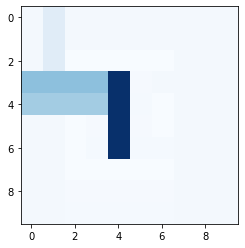

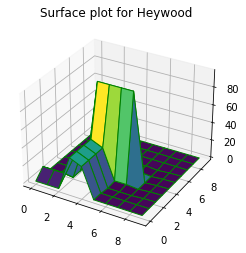

In [11]:
# importing libraries
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

region_action_scores = []
for learner in team.learners:
    if learner.program.rule.value_set[0] > learner.program.rule.value_set[1]:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[0], 'q': learner.program.rule.value_set[0]})
    else:
        region_action_scores.append({'region': learner.program.rule.region, 'action': learner.program.rule.action_set[1], 'q': learner.program.rule.value_set[1]})

sorted_region_action_scores = sorted(region_action_scores, key=lambda value: float(value['q']), reverse=True)
# print(sorted_region_action_scores)
# for record in sorted_region_action_scores:
#     print(record)
action_states = []
for record in sorted_region_action_scores:
    action = ''
    if record['action'] == 0:
        action = '\u2191'
    elif record['action'] == 1:
        action = '\u2193'
    elif record['action'] == 2:
        action = '\u2192'
    elif record['action'] == 3:
        action = '\u2190'

    for i in range(record['region'][3] - record['region'][2]+1):
        state = [0, 0]
        state[record['region'][0]] = record['region'][1]
        state[not record['region'][0]] = record['region'][2] + i
        
        # ensure we do not enter duplicate states
        found = 0
        for pair in action_states:
            if pair['state'] == (state[0], state[1]):
                found = 1
                
        if found == 0:
            action_states.append({'state': (state[0], state[1]), 'action': action, 'q': record['q'] })

# add in the rest of the states, either they are not visited, or illegal
for n in reversed(range(env.rows)):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['action']
#                 action = float(round(record['q'], 0))
        if found == 0:
            if not env.check_legal((n, m)):
                action = 'X'
            else:
                action = '?'
        print(f'{action} ', end='')
    print('\n')
    

q_map = np.zeros((env.rows, env.cols))

# add in the rest of the states, either they are not visited, or illegal
for n in range(env.rows):
    for m in range(env.cols):
        action = ''
        found = 0
        for record in action_states:
            if record['state'] == (n, m):
                found = 1
                action = record['q']
        if found == 0:
            if not env.check_legal((n, m)):
                action = -1
            else:
                action = 0
        q_map[(env.rows-1)-n][m] = action

plt.imshow(q_map, cmap='Blues', interpolation='nearest')
plt.show()

x = []
y = []
for i in range(env.cols):
    x.append(i)
    y.append(i)

Y, X = np.meshgrid(x, y)

fig = plt.figure()

# syntax for 3-D plotting
ax = plt.axes(projection ='3d')

# syntax for plotting
ax.plot_surface(X, Y, q_map, cmap ='viridis', edgecolor ='green')
ax.set_title(f'Surface plot for {envName}')
plt.show()